In [6]:
import gym
from gym import spaces
import numpy as np
import random
import quantstats as qs
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import talib as ta
from tqdm import tqdm
import warnings
import os
import tensorflow as tf
import pickle
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecCheckNan
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
df = pd.read_csv("D:/Code/tickers.csv")
df = df[df.tic == "^TNX"]
df = df.drop(["Unnamed: 0", "tic", "day"], axis=1)
df = df.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_values('date', ascending=True, inplace=True)

In [8]:
df['SMA_5'] = ta.SMA(df['Close'], 5)
df['SMA_14'] = ta.SMA(df['Close'], 14)
df['SMA_22'] = ta.SMA(df['Close'], 22)
# df['SMA_41'] = ta.SMA(df['Close'], 41)
# df['SMA_63'] = ta.SMA(df['Close'], 63)
df['EMA_5'] = ta.EMA(df['Close'], 5)
df['EMA_14'] = ta.EMA(df['Close'], 14)
df['EMA_22'] = ta.EMA(df['Close'], 22)
# df['EMA_41'] = ta.EMA(df['Close'], 41)
# df['EMA_63'] = ta.EMA(df['Close'], 63)
df['RSI'] = ta.RSI(df['Close'])
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = ta.MACD(df['Close'])
df['BBANDS_UPPER'], df['BBANDS_MIDDLE'], df['BBANDS_LOWER'] = ta.BBANDS(df['Close'])
df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'])
df['OBV'] = ta.OBV(df['Close'], df['Volume'])
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'])

In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(5694, 21)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5694 entries, 2000-02-23 to 2023-09-19
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5694 non-null   float64
 1   High           5694 non-null   float64
 2   Low            5694 non-null   float64
 3   Close          5694 non-null   float64
 4   Volume         5694 non-null   int64  
 5   SMA_5          5694 non-null   float64
 6   SMA_14         5694 non-null   float64
 7   SMA_22         5694 non-null   float64
 8   EMA_5          5694 non-null   float64
 9   EMA_14         5694 non-null   float64
 10  EMA_22         5694 non-null   float64
 11  RSI            5694 non-null   float64
 12  MACD           5694 non-null   float64
 13  MACD_SIGNAL    5694 non-null   float64
 14  MACD_HIST      5694 non-null   float64
 15  BBANDS_UPPER   5694 non-null   float64
 16  BBANDS_MIDDLE  5694 non-null   float64
 17  BBANDS_LOWER   5694 non-null   flo

In [12]:
df.head(10)

,Open,High,Low,Close,Volume,SMA_5,SMA_14,SMA_22,EMA_5,EMA_14,...,RSI,MACD,MACD_SIGNAL,MACD_HIST,BBANDS_UPPER,BBANDS_MIDDLE,BBANDS_LOWER,ADX,OBV,ATR
date,,,,,,,,,,,,,,,,,,,,,
2000-02-23,6.393,6.427,6.367,6.427,0,6.4736,6.544786,6.585909,6.458770,6.530696,...,42.805409,-0.054294,-0.030390,-0.023905,6.638687,6.4736,6.308513,28.618567,0.0,0.097798
2000-02-24,6.388,6.392,6.324,6.346,0,6.4334,6.535571,6.570545,6.421180,6.506070,...,38.599755,-0.064113,-0.037134,-0.026978,6.605170,6.4334,6.261630,30.315138,0.0,0.098169
2000-02-25,6.367,6.482,6.337,6.341,0,6.3878,6.523000,6.554955,6.394453,6.484060,...,38.349275,-0.071473,-0.044002,-0.027471,6.503159,6.3878,6.272441,30.426004,0.0,0.101514
2000-02-28,6.333,6.418,6.333,6.414,0,6.3740,6.507500,6.542864,6.400969,6.474719,...,44.056976,-0.070603,-0.049322,-0.021280,6.450451,6.3740,6.297549,30.560092,0.0,0.100335
2000-02-29,6.418,6.448,6.405,6.409,0,6.3874,6.493929,6.530318,6.403646,6.465957,...,43.758146,-0.069515,-0.053361,-0.016154,6.460114,6.3874,6.314686,30.220156,0.0,0.096240
2000-03-01,6.388,6.405,6.358,6.379,0,6.3778,6.473214,6.518091,6.395431,6.454362,...,41.920922,-0.070263,-0.056741,-0.013522,6.438797,6.3778,6.316803,30.310323,0.0,0.093008
2000-03-02,6.401,6.431,6.379,6.396,0,6.3878,6.454643,6.505773,6.395620,6.446581,...,43.371846,-0.068693,-0.059131,-0.009561,6.440494,6.3878,6.335106,29.984327,0.0,0.090079
2000-03-03,6.396,6.396,6.337,6.371,0,6.3938,6.436786,6.494591,6.387414,6.436503,...,41.721154,-0.068674,-0.061040,-0.007634,6.427060,6.3938,6.360540,30.055755,0.0,0.087859
2000-03-06,6.405,6.426,6.400,6.409,0,6.3928,6.427500,6.486000,6.394609,6.432836,...,45.138979,-0.064845,-0.061801,-0.003044,6.423794,6.3928,6.361806,29.640530,0.0,0.085512


In [13]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_investment=10000, commission_fee=0.001):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.initial_investment = initial_investment
        self.commission_fee = commission_fee
        self.current_step = 0

        # Action space: 0 = sell, 1 = hold, 2 = buy
        self.action_space = spaces.Discrete(3)

        # Observation space: Every column of the dataframe, money in hand, stock holding, current investment
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(df.columns) + 3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.current_balance = self.initial_investment
        self.stock_holding = 0
        self.current_investment = 0
        return self._next_observation()

    def _next_observation(self):
        obs = np.concatenate([self.df.iloc[self.current_step].values, [self.current_balance], [self.stock_holding], [self.current_investment]])
        return obs

    def step(self, action):
        self.current_step += 1

        if action == 0:  # Sell
            sell_value = self.df.iloc[self.current_step]['Close'] * self.stock_holding
            self.current_balance += sell_value - (sell_value * self.commission_fee)
            self.stock_holding = 0
        elif action == 1:  # Hold
            pass
        elif action == 2:  # Buy
            buy_value = self.df.iloc[self.current_step]['Close'] * (self.current_balance / self.df.iloc[self.current_step]['Close'])
            self.current_balance -= buy_value + (buy_value * self.commission_fee)
            self.stock_holding = buy_value / self.df.iloc[self.current_step]['Close']
            self.current_investment += buy_value

        done = self.current_step == len(self.df) - 1
        if done:
            portfolio_value = self.current_balance + (self.df.iloc[self.current_step]['Close'] * self.stock_holding)
            reward = portfolio_value - self.initial_investment
        else:
            reward = 0

        obs = self._next_observation()

        return obs, reward, done, {}

    def render(self, mode='human', close=False):
        pass

In [14]:
# %pip install QuantStats

In [15]:
# Split the dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Create and wrap the environment for training
train_env = StockTradingEnv(train_df)
train_env = DummyVecEnv([lambda: train_env])

# Create and train the DQN model with tqdm progress bar
total_timesteps = 100_000
model = DQN("MlpPolicy", train_env, verbose=0)
with tqdm(total=total_timesteps, desc="Training DQN") as pbar:
    for _ in range(total_timesteps):
        model.learn(total_timesteps=1)
        pbar.update(1)

# Save the trained model
model.save("dqn_stock_trading")

# Create and wrap the environment for testing
test_env = StockTradingEnv(test_df)
test_env = DummyVecEnv([lambda: test_env])

# Reset the environment
obs = test_env.reset()

d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "
Training DQN: 100%|██████████| 100000/100000 [18:33<00:00, 89.79it/s]


In [16]:
# %pip install --upgrade jupyter
# %pip install --upgrade matplotlib

In [ ]:
# %pip install pyfolio

Testing and Backtesting: 100%|██████████| 1138/1138 [00:03<00:00, 353.57it/s]



Backtest Statistics:
Total Return: -174091.53%
Sharpe Ratio: -0.4712


d:\Env\StockReinLearVenv\lib\site-packages\empyrical\stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
d:\Env\StockReinLearVenv\lib\site-packages\empyrical\stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2018-12-24
End date,2023-09-19
Total months,54
,Backtest
Annual return,-0.0%
Cumulative returns,-0.0%
Annual volatility,81888.6%
Sharpe ratio,-0.47
Calmar ratio,-0.00
Stability,NaN
Max drawdown,-100.1%


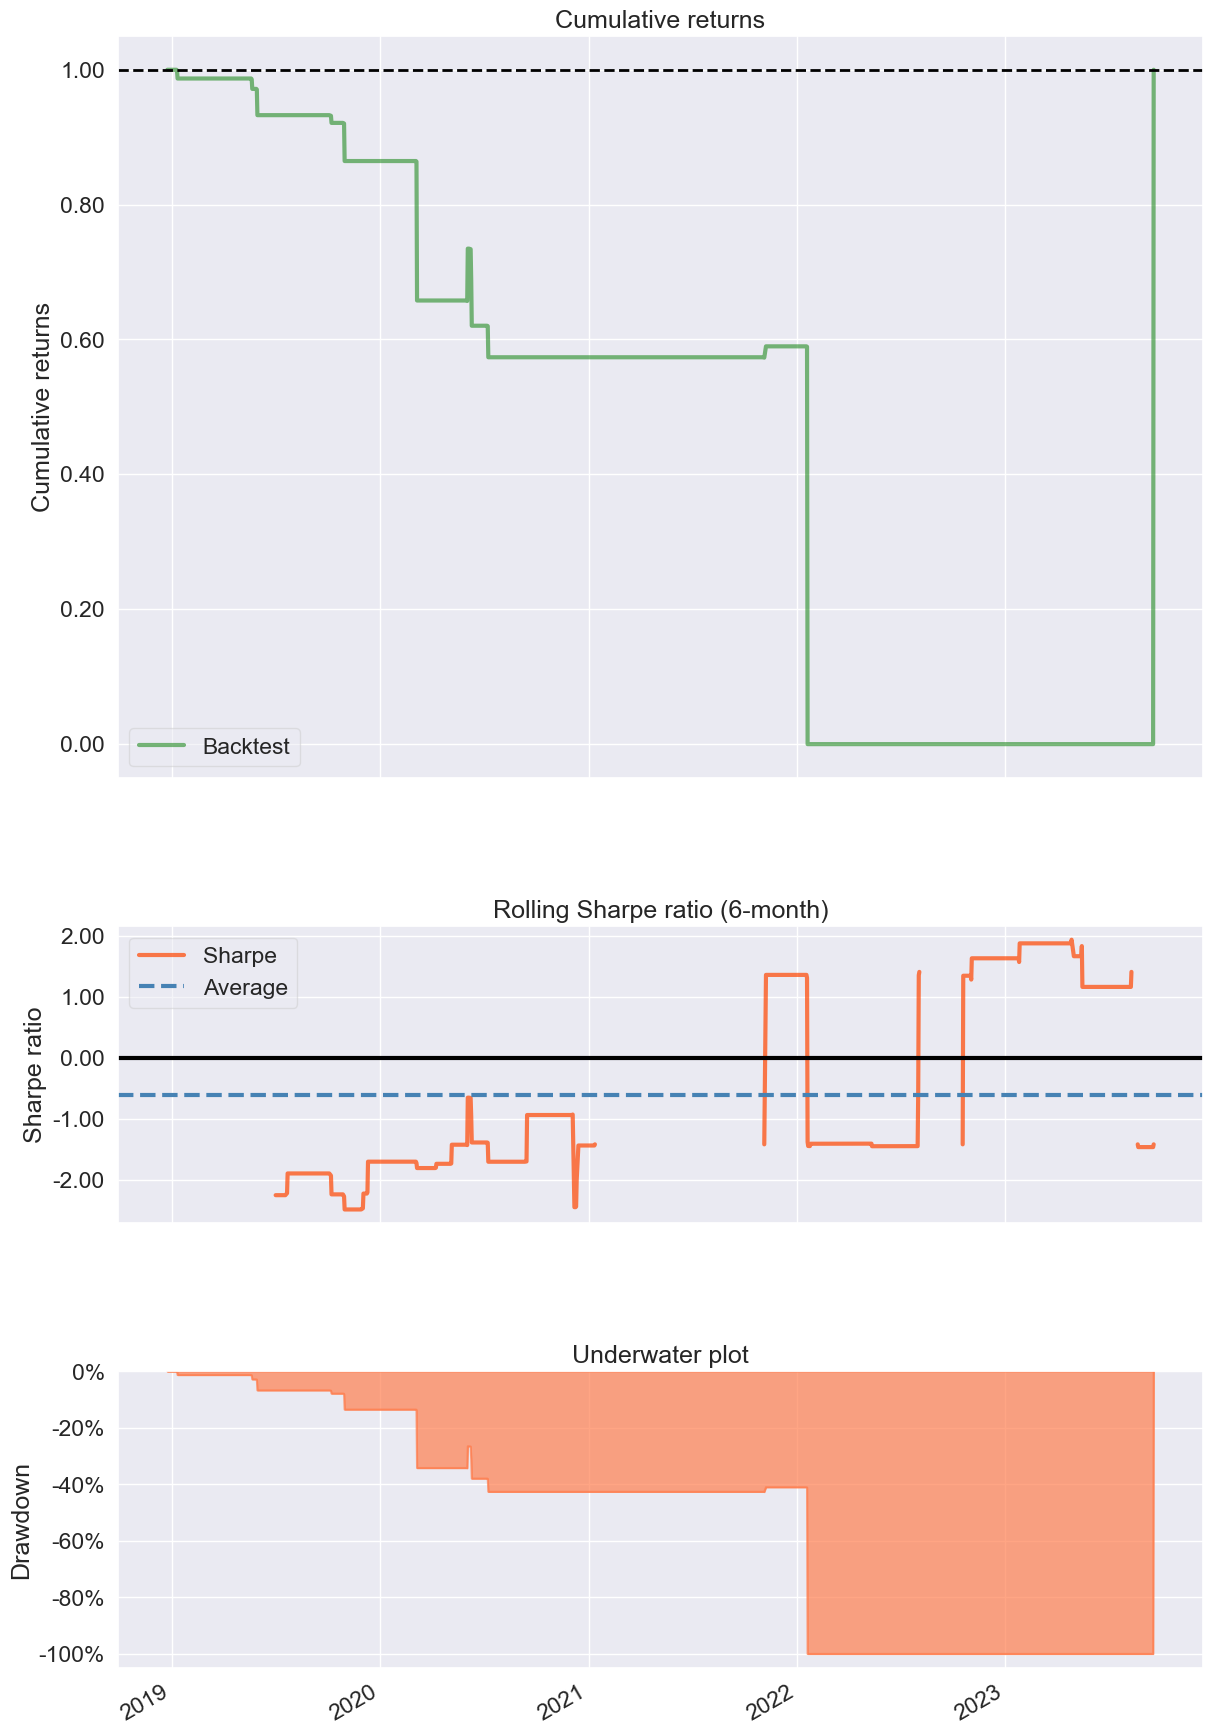

In [22]:
import pyfolio as pf

# Lists to store trading history
dates = []
actions = []
rewards = []
portfolio_values = []

# Reset the environment for testing
obs = test_env.reset()

# Perform the backtest
with tqdm(total=len(test_df) - 1, desc="Testing and Backtesting") as pbar:
    for i in range(len(test_df) - 1):
        action, _ = model.predict(obs)
        obs, reward, _, _ = test_env.step(action)

        current_date = test_df.index[i + 1]
        dates.append(current_date)
        actions.append(action)
        rewards.append(reward)

        # Access relevant information directly from the StockTradingEnv instance
        current_balance = test_env.envs[0].current_balance
        stock_holding = test_env.envs[0].stock_holding
        stock_price = test_env.envs[0].df.loc[current_date, 'Close']

        portfolio_values.append(current_balance + (stock_price * stock_holding))

        pbar.update(1)

# Create a DataFrame for the backtest results
backtest_df = pd.DataFrame({
    'Date': dates,
    'Action': actions,
    'Reward': rewards,
    'Portfolio Value': portfolio_values
})
backtest_df.set_index('Date', inplace=True)

# Calculate daily returns
returns = backtest_df['Portfolio Value'].pct_change().dropna()

# Print backtest statistics
print('\nBacktest Statistics:')
print('Total Return: {:.2%}'.format(returns.sum()))
print('Sharpe Ratio: {:.4f}'.format(qs.stats.sharpe(returns)))

# Create a pyfolio tear sheet
pf.create_simple_tear_sheet(returns)